<a href="https://colab.research.google.com/github/SrinilayVelugoti/Melanoma-Detection-Assignment/blob/master/Copy_of_Starter_code_Assignment_CNN_Skin_Cancer_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
!git clone https://github.com/SrinilayVelugoti/Melanoma-Detection-Assignment.git

Cloning into 'Melanoma-Detection-Assignment'...
remote: Enumerating objects: 2232, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2232 (delta 2), reused 0 (delta 0), pack-reused 2226
Receiving objects: 100% (2232/2232), 760.81 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (2360/2360), done.


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(r"/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
def image_stats(_dir) :
    l = [(str(i),str(i).split('/')[-2]) for i in _dir.glob('*/*.jpg')]
    dir_paths = np.array(l)[:,0]
    val_counts = np.array(l)[:,1]
    df = pd.Series(val_counts).value_counts()
    df = df.reset_index()
    df.columns = ['class','count']
    df['percent'] = 100 * df['count'] / df['count'].sum()
    display(df)
    return dir_paths,df

In [6]:
dir_paths,tr_df = image_stats(data_dir_train)


class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

In [7]:
test_path,ts_df = image_stats(data_dir_test)

class  count    percent
0                    melanoma     16  13.559322
1        basal cell carcinoma     16  13.559322
2           actinic keratosis     16  13.559322
3  pigmented benign keratosis     16  13.559322
4                       nevus     16  13.559322
5              dermatofibroma     16  13.559322
6     squamous cell carcinoma     16  13.559322
7             vascular lesion      3   2.542373
8        seborrheic keratosis      3   2.542373

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Creating the Test and Validation sets , 80% of data goes to training while the validation set has 20% of the data
# Each of the images are of size (180,180,3) -> 180 and 180 are height and width while 3 is the noof channels
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
# Preparing Sample images of each class
sample_class = {}
for j in dir_paths :
    class_holder = j.split('/')[-2]
    if sample_class :
        if class_holder in sample_class.keys() :
            continue
        sample_class[class_holder] = j
    sample_class[class_holder] = j

    if len(sample_class) == len(class_names) :
        break





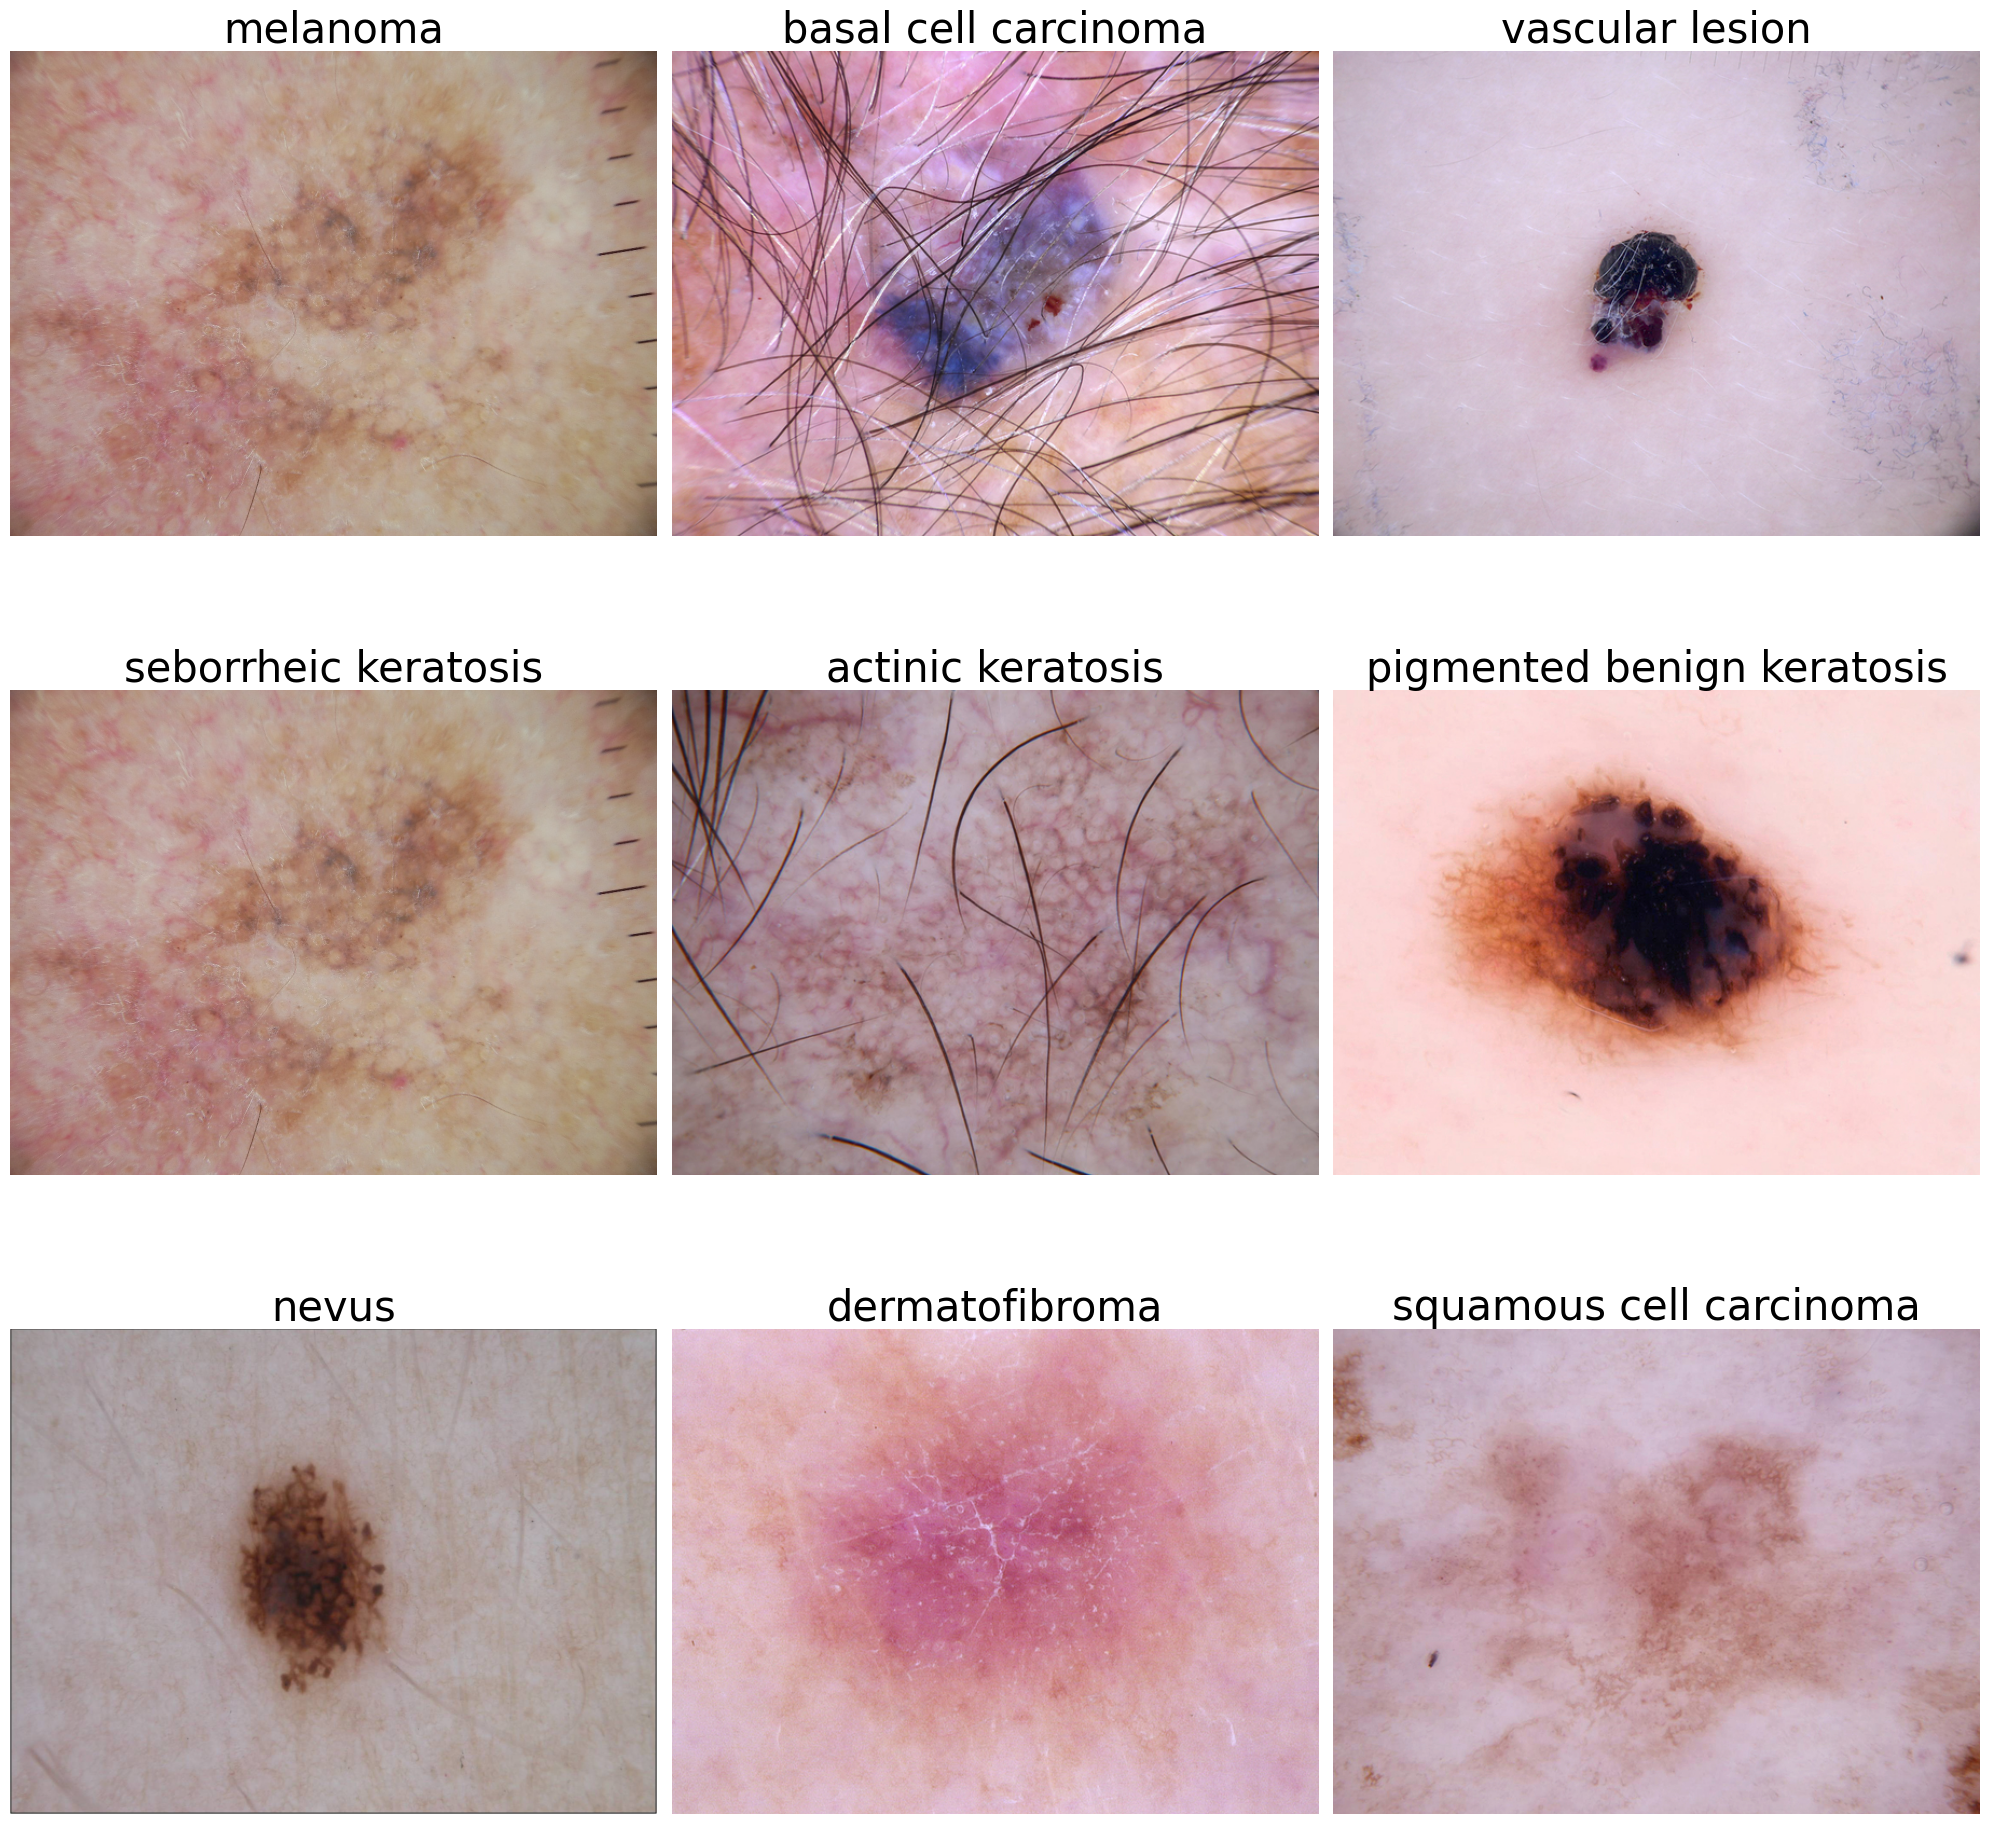

In [12]:
fig,ax = plt.subplots(3,3,figsize=(20,20))
for idx,(cat,val) in enumerate(sample_class.items()) :
    idx2 = idx % 3
    idx1 = idx // 3
    ax[idx1,idx2].imshow(PIL.Image.open(val))
    ax[idx1,idx2].axis('off')
    ax[idx1,idx2].set_title(cat,fontsize=30)
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.Dropout(0.1),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 121ms/step - loss: 2.1064 - accuracy: 0.1897 - val_loss: 2.0475 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 1.9508 - accuracy: 0.2545 - val_loss: 1.8719 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7320 - accuracy: 0.3700 - val_loss: 1.5372 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.5549 - accuracy: 0.4392 - val_loss: 1.7576 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4014 - accuracy: 0.5056 - val_loss: 1.4523 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.2911 - accuracy: 0.5547 - val_loss: 1.4146 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.2208 - accuracy: 0.5698 - val_loss: 1.6666 - val_accuracy: 0.4787
Epoch 8/20


### Visualizing training results

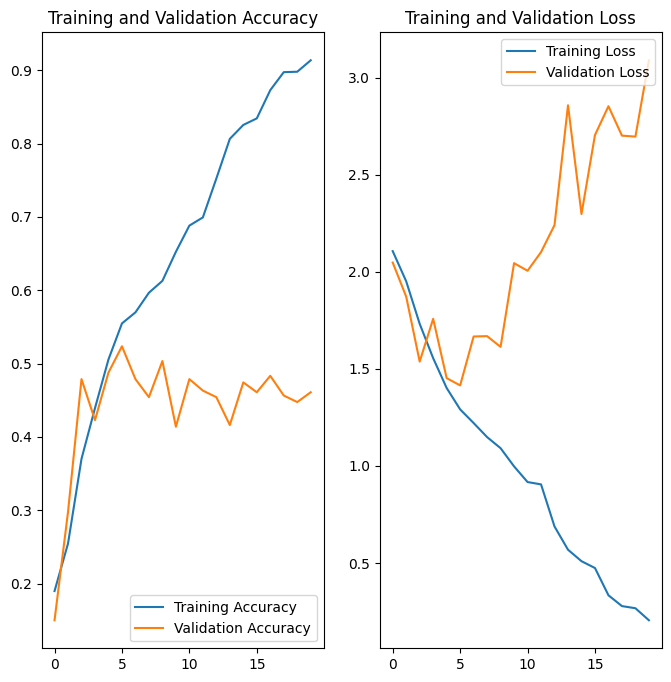

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Train the Same model this time with Dropouts and Batch Normalization

In [19]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 176, 176, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 176, 176, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                 

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 125ms/step - loss: 10.6047 - accuracy: 0.2506 - val_loss: 12.5989 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 121ms/step - loss: 2.4265 - accuracy: 0.2176 - val_loss: 11.8609 - val_accuracy: 0.2148
Epoch 3/20
56/56 [==============================] - 7s 120ms/step - loss: 2.1094 - accuracy: 0.2946 - val_loss: 6.0019 - val_accuracy: 0.2573
Epoch 4/20
56/56 [==============================] - 7s 120ms/step - loss: 1.9940 - accuracy: 0.3248 - val_loss: 5.4833 - val_accuracy: 0.2998
Epoch 5/20
56/56 [==============================] - 7s 120ms/step - loss: 1.8457 - accuracy: 0.3823 - val_loss: 19.5014 - val_accuracy: 0.2148
Epoch 6/20
56/56 [==============================] - 7s 119ms/step - loss: 1.5763 - accuracy: 0.4548 - val_loss: 13.7392 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 7s 120ms/step - loss: 1.5006 - accuracy: 0.4766 - val_loss: 13.7293 - val_accuracy: 0.3535

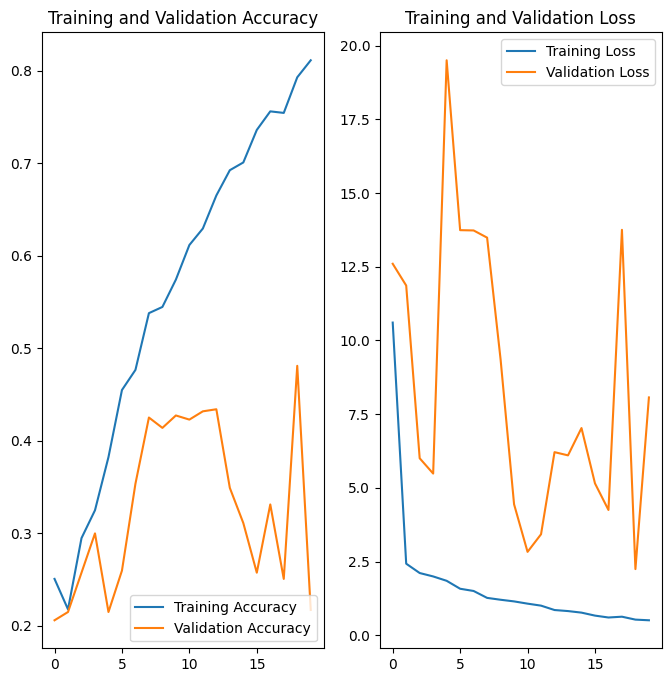

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### It can be clearly seen that the model has overfit . While the training accuracy shows clear signs of increasing , the testing accuracy remains constant.
### The same can be observed with loss too . While the Training Loss keeps moving down , the testing loss keeps increasing

In [22]:
datagen = ImageDataGenerator(
        # rescale=1./255,
        rotation_range = 25,
        width_shift_range = .05,
        height_shift_range = .03,
        fill_mode = 'nearest',
        # vertical_flip=True,
        shear_range = 0.25,
        zoom_range = 0.2,
        horizontal_flip=True,
        validation_split = .2)

train_ds= datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
         subset='training',
        class_mode = 'categorical'
        )
val_ds = datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='validation',
        class_mode = 'categorical'
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [23]:
train_ds.class_indices


{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [24]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 84, 64)        36928     
                                                      

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 37s 624ms/step - loss: 2.1629 - accuracy: 0.2563 - val_loss: 1.8243 - val_accuracy: 0.3131
Epoch 2/20
57/57 [==============================] - 33s 583ms/step - loss: 1.6352 - accuracy: 0.4301 - val_loss: 1.8410 - val_accuracy: 0.3784
Epoch 3/20
57/57 [==============================] - 44s 780ms/step - loss: 1.7468 - accuracy: 0.3905 - val_loss: 2.1385 - val_accuracy: 0.2973
Epoch 4/20
57/57 [==============================] - 34s 603ms/step - loss: 1.5863 - accuracy: 0.4646 - val_loss: 1.8973 - val_accuracy: 0.4595
Epoch 5/20
57/57 [==============================] - 34s 591ms/step - loss: 1.4539 - accuracy: 0.4942 - val_loss: 2.3198 - val_accuracy: 0.3919
Epoch 6/20
57/57 [==============================] - 35s 608ms/step - loss: 1.4336 - accuracy: 0.5047 - val_loss: 2.2708 - val_accuracy: 0.4347
Epoch 7/20
57/57 [==============================] - 34s 594ms/step - loss: 1.3882 - accuracy: 0.5159 - val_loss: 2.1963 - val_accuracy: 0.4572

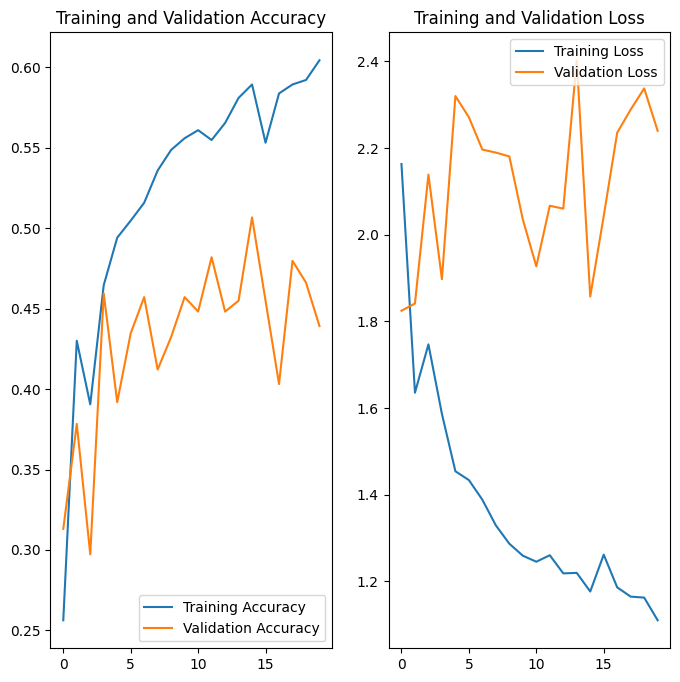

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 dropout_2 (Dropout)         (None, 176, 176, 32)      0         
                                                                 
 batch_normalization_2 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                 

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 40s 656ms/step - loss: 8.3475 - accuracy: 0.2379 - val_loss: 2.1836 - val_accuracy: 0.1689
Epoch 2/20
57/57 [==============================] - 35s 609ms/step - loss: 2.1806 - accuracy: 0.2903 - val_loss: 2.1851 - val_accuracy: 0.1667
Epoch 3/20
57/57 [==============================] - 33s 594ms/step - loss: 2.0511 - accuracy: 0.3075 - val_loss: 2.3379 - val_accuracy: 0.1216
Epoch 4/20
57/57 [==============================] - 35s 608ms/step - loss: 1.9220 - accuracy: 0.3571 - val_loss: 2.5484 - val_accuracy: 0.1689
Epoch 5/20
57/57 [==============================] - 35s 612ms/step - loss: 1.8170 - accuracy: 0.3955 - val_loss: 4.1181 - val_accuracy: 0.2275
Epoch 6/20
57/57 [==============================] - 35s 608ms/step - loss: 1.8321 - accuracy: 0.3783 - val_loss: 7.4185 - val_accuracy: 0.1892
Epoch 7/20
57/57 [==============================] - 38s 672ms/step - loss: 1.6911 - accuracy: 0.4256 - val_loss: 7.7715 - val_accuracy: 0.1554

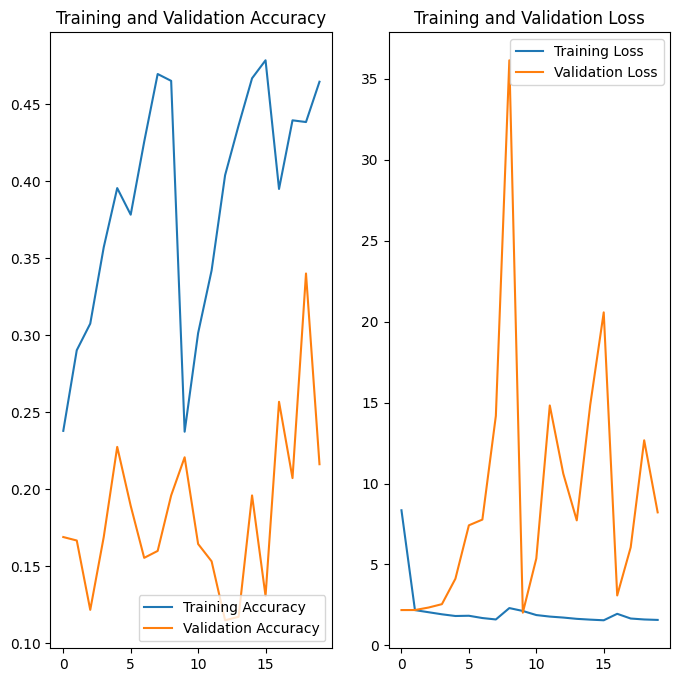

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## It can be seen that while the rate of overfitting reduced , testing accuracies have both come down a little bit


In [30]:
tr_df

class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

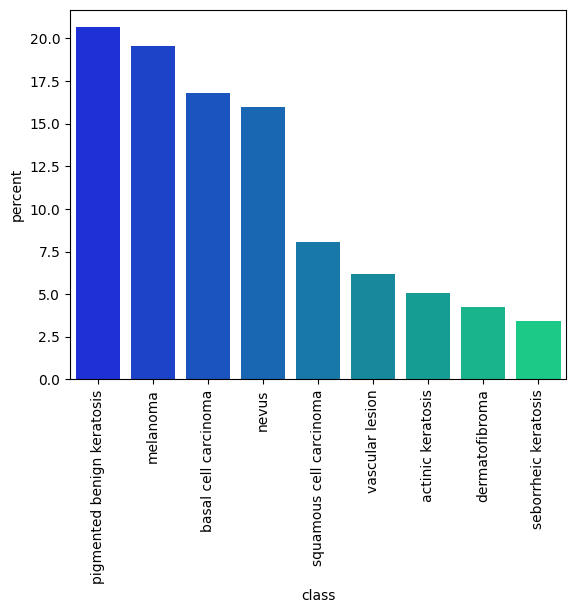

In [31]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()


## It can be observed that the classes starting from squamous cell carcinoma have very few values
## Dealing with the imbalance here might increase accuracy
### Pigmened benign keratosis has the highest samples , while seborrheic keratosis has the least samples in the dataset

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.
4. Probabilities Generated from Random Sampling - [0.6756491446802199,
 0.6918382907925669,
 0.8574535085484989,
 0.7563134692683174,
 0.7266573083999999]


In [14]:
# path_to_training_dataset="To do"
import Augmentor
import numpy as np
p_rotate_norm = np.random.uniform(0.3,.65)
p_skew = np.random.uniform(0.4,.65)
p_flip = np.random.uniform(0.4,.6)
p_rotate = np.random.uniform(0.3,.55)
p_distortion = np.random.uniform(0.15,.45)
# p_rotate_norm,p_skew,p_flip,p_rotate, p_distortion = [0.6756491446802199,
#  0.6918382907925669,
#  0.8574535085484989,
#  0.7563134692683174,
#  0.7266573083999999]
path_to_training_dataset = "/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=p_rotate_norm, max_left_rotation=25, max_right_rotation=25)
    p.skew_corner(probability=p_skew)
    p.flip_left_right(probability=p_flip)
    # p.rotate_random_90(probability = p_rotate)
    p.random_distortion(probability = p_distortion,grid_width = 10,grid_height=10,magnitude=np.random.randint(5,9))
    p.sample(1900) ## We are adding 755 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6940601A80>: 100%|██████████| 755/755 [00:28<00:00, 26.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69404AF640>: 100%|██████████| 755/755 [00:30<00:00, 24.72 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6940430340>: 100%|██████████| 755/755 [00:33<00:00, 22.29 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F69404AE500>: 100%|██████████| 755/755 [02:41<00:00,  4.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F69406CB6D0>: 100%|██████████| 755/755 [02:29<00:00,  5.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6940688AC0>: 100%|██████████| 755/755 [00:28<00:00, 26.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F694073F310>: 100%|██████████| 755/755 [01:13<00:00, 10.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6940316C50>: 100%|██████████| 755/755 [00:29<00:00, 25.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69407A9A50>: 100%|██████████| 755/755 [00:29<00:00, 25.84 Samples/s]


In [15]:
[p_rotate_norm,
p_skew,
p_flip,
p_rotate,
p_distortion]

[0.3148724496832792,
 0.4875163466172174,
 0.5766595847932982,
 0.4438782986842621,
 0.3477861545899188]

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [16]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6795


### Lets see the distribution of augmented data after adding new images to the original training data.

In [17]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list= os.path.join(data_dir_train, '*','output', '*.jpg')
path_list_new[0]

'/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010156.jpg_707fdf5f-dac0-47f2-9ef7-e7344d7c8819.jpg'

In [18]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
np.unique(lesion_list_new)

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

In [19]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
# dataframe_dict_new

In [20]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','class'])
# new_df = original_df.append(df2)

In [21]:
df2  = df2['class'].value_counts().reset_index()
df2.columns = ['class','count']
# df2['percent'] = 100 * df['count'] / df['count'].sum()
df2

class  count
0                    melanoma    755
1        basal cell carcinoma    755
2             vascular lesion    755
3        seborrheic keratosis    755
4           actinic keratosis    755
5  pigmented benign keratosis    755
6                       nevus    755
7              dermatofibroma    755
8     squamous cell carcinoma    755

In [22]:
tr_df = tr_df.drop('percent',axis=1)
tr_df = pd.concat([tr_df,df2],axis=0)
tr_df = tr_df.groupby(['class'])['count'].sum().reset_index()


In [23]:
tr_df['percent'] = 100 * tr_df['count'] / tr_df['count'].sum()
tr_df

class  count    percent
0           actinic keratosis    869   9.619216
1        basal cell carcinoma   1131  12.519371
2              dermatofibroma    850   9.408900
3                    melanoma   1193  13.205667
4                       nevus   1112  12.309055
5  pigmented benign keratosis   1217  13.471331
6        seborrheic keratosis    832   9.209652
7     squamous cell carcinoma    936  10.360859
8             vascular lesion    894   9.895949

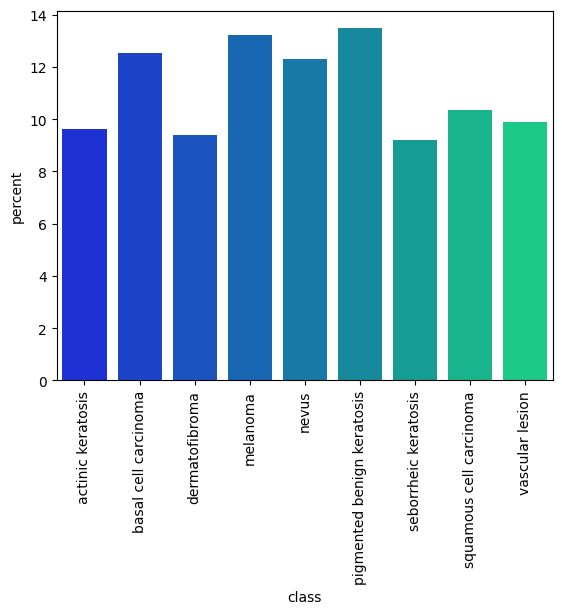

In [24]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [25]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [26]:
data_dir_train="/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)

Found 9034 files belonging to 9 classes.
Using 7228 files for training.
Using 1806 files for validation.


In [27]:
# User
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:**  Train your model

In [32]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_3 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 32)       

In [33]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
226/226 [==============================] - 35s 137ms/step - loss: 3.9404 - accuracy: 0.2247 - val_loss: 95.6214 - val_accuracy: 0.1229
Epoch 2/30
226/226 [==============================] - 31s 137ms/step - loss: 2.0067 - accuracy: 0.2532 - val_loss: 32.2009 - val_accuracy: 0.1639
Epoch 3/30
226/226 [==============================] - 31s 137ms/step - loss: 1.9780 - accuracy: 0.2530 - val_loss: 2.0879 - val_accuracy: 0.2514
Epoch 4/30
226/226 [==============================] - 31s 138ms/step - loss: 1.9139 - accuracy: 0.2708 - val_loss: 26.3670 - val_accuracy: 0.2104
Epoch 5/30
226/226 [==============================] - 31s 137ms/step - loss: 1.8314 - accuracy: 0.2968 - val_loss: 18.0818 - val_accuracy: 0.2403
Epoch 6/30
226/226 [==============================] - 31s 138ms/step - loss: 1.7609 - accuracy: 0.3219 - val_loss: 6.4640 - val_accuracy: 0.1971
Epoch 7/30
226/226 [==============================] - 31s 138ms/step - loss: 1.6907 - accuracy: 0.3311 - val_loss: 19.0262 - v

KeyboardInterrupt: 

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 41, 41, 32)       

In [39]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
226/226 [==============================] - 6s 18ms/step - loss: 1.8620 - accuracy: 0.2836 - val_loss: 1.5780 - val_accuracy: 0.3976
Epoch 2/30
226/226 [==============================] - 3s 15ms/step - loss: 1.5137 - accuracy: 0.4101 - val_loss: 1.4617 - val_accuracy: 0.4419
Epoch 3/30
226/226 [==============================] - 3s 15ms/step - loss: 1.3905 - accuracy: 0.4586 - val_loss: 1.4831 - val_accuracy: 0.4612
Epoch 4/30
226/226 [==============================] - 4s 16ms/step - loss: 1.3368 - accuracy: 0.4799 - val_loss: 1.3663 - val_accuracy: 0.4745
Epoch 5/30
226/226 [==============================] - 3s 15ms/step - loss: 1.2475 - accuracy: 0.5115 - val_loss: 1.2743 - val_accuracy: 0.5188
Epoch 6/30
226/226 [==============================] - 3s 15ms/step - loss: 1.1807 - accuracy: 0.5434 - val_loss: 1.2843 - val_accuracy: 0.5244
Epoch 7/30
226/226 [==============================] - 4s 16ms/step - loss: 1.1198 - accuracy: 0.5679 - val_loss: 1.3167 - val_accuracy: 0.5116

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [48]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),


    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Dropout(0.43),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.43),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.43),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 89, 89, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 dropout_17 (Dropout)        (None, 87, 87, 16)        0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 43, 43, 16)        0         
 ng2D)                                               

In [49]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
226/226 [==============================] - 6s 20ms/step - loss: 1.8724 - accuracy: 0.2687 - val_loss: 1.8855 - val_accuracy: 0.3649
Epoch 2/40
226/226 [==============================] - 5s 21ms/step - loss: 1.5269 - accuracy: 0.4109 - val_loss: 1.7530 - val_accuracy: 0.4053
Epoch 3/40
226/226 [==============================] - 4s 19ms/step - loss: 1.3969 - accuracy: 0.4613 - val_loss: 1.7062 - val_accuracy: 0.4286
Epoch 4/40
226/226 [==============================] - 4s 19ms/step - loss: 1.3386 - accuracy: 0.4806 - val_loss: 1.6950 - val_accuracy: 0.3704
Epoch 5/40
226/226 [==============================] - 5s 20ms/step - loss: 1.2580 - accuracy: 0.5143 - val_loss: 1.6472 - val_accuracy: 0.4014
Epoch 6/40
226/226 [==============================] - 4s 19ms/step - loss: 1.1860 - accuracy: 0.5455 - val_loss: 1.6081 - val_accuracy: 0.4097
Epoch 7/40
226/226 [==============================] - 5s 20ms/step - loss: 1.1109 - accuracy: 0.5739 - val_loss: 1.5281 - val_accuracy: 0.4457

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()